In [1]:
import modules.fs_modules as fs_mods
import pandas as pd
import plotnine as p9

Note that you need to set up your mercury ssh key in a .env file in this directory, under the name "MERCURY_KEY". \
Instructions for how to get your ssh key are available in the mercury documentation.

# 1. Download all years along with updated metadata files by running fdsloader using submit_erouhani.sh

# 2. Get bash script command for unzipping and run unzip.sh

In [4]:
# note: get_trans_zips_info takes two optional inputs that determine what years and what date range
# to look for transcript files in on the fdsloader zips folder -- change these as you need.

new_trans, bash_array = fs_mods.get_trans_zips_info(suppress_print = True)
new_years = list(new_trans.keys())
print(f'int version of new_years for future use: \n{[int(x) for x in new_years]}')
print(f'Insert this into unzip.sh WITHOUT OUTSIDE QUOTATIONS:\n{bash_array}')

Logging into mercury at /project/FactSet/fdsloader/zips/...
Mercury login succesful. Returning sftp.
int version of new_years for future use: 
[2007, 2008, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Insert this into unzip.sh WITHOUT OUTSIDE QUOTATIONS:
("tr_history_2007_full_2577.zip" "tr_history_2008_full_2577.zip" "tr_history_2010_full_2577.zip" "tr_history_2013_full_2577.zip" "tr_history_2014_full_2577.zip" "tr_history_2015_full_2577.zip" "tr_history_2016_full_2577.zip" "tr_history_2017_full_2577.zip" "tr_history_2018_full_2577.zip" "tr_history_2019_full_2577.zip" "tr_history_2020_full_2577.zip" "tr_history_2021_full_2577.zip" "tr_history_2022_full_2577.zip" "tr_history_2023_full_2577.zip" "tr_history_2024_full_2577.zip")


# 3. Download metadata datasets from FactSet

In [1]:
# make sure you confirm that the right files have been downloaded
fs_mods.download_metas()

Logging into mercury at /project/FactSet/fdsloader/zips...
Mercury login succesful. Returning sftp.
Done downloading ce_events_full_49625.zip
Done downloading ent_entity_advanced_v1_full_8445.zip
Done downloading sym_cusip_v1_full_9619.zip
Done downloading ce_hub_v1_full_38543.zip
Could not delete ent_entity_advanced_v1_full_8445
Could not delete ce_hub_v1_full_38181
Could not delete ce_events_full_49224


# 4. Create factset dataset for comparison

## 4A. Import and combine all needed factset identification datasets and events dataset

In [ ]:
#get all factset id datasets
#dataset that links reportids to company ids
#the zips needed are: ce_events_full, ce_hub_v1_full, ent_entity_advanced_v1_full, sym_cusip_v1_full (reports is in events zip)
cols = pd.read_csv('./id_docs/ce_reports.txt', encoding='unicode_escape', nrows=1, sep='|').columns
report_df = pd.read_csv('./id_docs/ce_reports.txt', usecols=cols, encoding='unicode_escape', sep='|', low_memory=False)
report_df = report_df[['REPORT_ID', 'EVENT_ID', 'FACTSET_ENTITY_ID']]

#dataset that connects company ids to company names
ent_df = pd.read_csv('./id_docs/ent_entity_coverage.txt', sep='|', encoding='unicode-escape', low_memory=False)
ent_df = ent_df[['FACTSET_ENTITY_ID', 'ENTITY_NAME', 'ENTITY_PROPER_NAME', 'ISO_COUNTRY']]

#merge report and entity datasets
reports = report_df.merge(ent_df, on='FACTSET_ENTITY_ID', how='left')

#dataset that connects company ids to fysm id
fsym_id = pd.read_csv('./id_docs/ce_sec_entity.txt', encoding='unicode_escape', sep='|')

#dataset that connects fysm id to company cusip
cusip_df = pd.read_csv('./id_docs/sym_cusip.txt', sep="|", encoding='unicode_escape')

#merge previous two 
firmid_df = cusip_df.merge(fsym_id, on='FSYM_ID', how='inner').groupby('FACTSET_ENTITY_ID').agg(list).reset_index()

#merge all datasets together
fs_ref = reports.merge(firmid_df, on='FACTSET_ENTITY_ID', how='left')
fs_ref.to_csv('../data_ref/factset_reference.csv')

#get factset events dataset for comparison
cols = pd.read_csv('./id_docs/ce_events.txt', encoding='unicode_escape', nrows=1, sep='|').columns
events = pd.read_csv('./id_docs/ce_events.txt', sep='|', encoding='unicode-escape', usecols=cols, low_memory=False)

#filter events through 2024
events = events[events.PROJECTED != 1] # these are events expected by factset but not collected
# this is a sanity check since some dates exist beyond what is realistic
events = events[(pd.DatetimeIndex(events.EVENT_DATETIME_UTC).year < 2025) & (pd.DatetimeIndex(events.EVENT_DATETIME_UTC).year > 2000)]
display(events.head())

# Merge events with id_info to build factset master event-id dataset -- 
# Note: We don't have access to all these files. This will be remedied later
all_fs = fs_ref.merge(events, on='EVENT_ID', how='inner')
all_fs.drop(columns=['EVENT_ID', 'EVENT_TYPE', 'MARKET_TIME', 'FISCAL_PERIOD', 'FISCAL_YEAR', 'FISCAL_YEAR_NORM', 'PROJECTED', 'EVENT_GROUP_ID', 'URL_PR'], inplace=True)
all_fs.to_csv('../data_ref/factset_master_INACCESSIBLES_INCLUDED.csv', index=False)

## 4B. Build comparison dataset

### a. Build datafrane of all factset xmls available to us by going through the folders on mercury

In [58]:
# get dataframe of all files accessible to us for years we are looking into
new_accessibles = fs_mods.get_all_names(new_years)

# add column to add recency bias
new_accessibles['stat'] = 'new'

#concatenate to previous dataframe of all files
old_accessibles = pd.read_csv('../data_ref/all_fs_files.csv', low_memory=False)
old_accessibles['stat'] = 'old'

# concatenate
all_accessibles = pd.concat([old_accessibles, new_accessibles])

# standardize report_id and date formats
all_accessibles.report_id = all_accessibles.report_id.astype(int).astype(str)
all_accessibles.date = pd.to_datetime(all_accessibles.date, format='mixed').dt.strftime('%Y-%m-%d')

# drop duplicates
# sort to make sure duplicates favor new files 
# note: this should rarely make a difference but is a failsafe
all_accessibles.sort_values('stat', inplace=True)
updated_accessibles = all_accessibles.drop_duplicates(subset='file_name').copy()

# drop unneeded column
updated_accessibles.drop(columns=['stat'], inplace=True)

print(f'{updated_accessibles.shape[0]-old_accessibles.shape[0]} new files.')

# save new file
updated_accessibles.to_csv('../data_ref/all_fs_files.csv', index=False)

Logging into mercury at /project/FactSet/fdsloader/unzipped_data...
Mercury login succesful. Returning sftp.
21846 unique files for 2007
Originally had 38346 files.
------------------------------
21781 unique files for 2008
Originally had 43556 files.
------------------------------
28593 unique files for 2010
Originally had 57180 files.
------------------------------
28836 unique files for 2013
Originally had 57649 files.
------------------------------
29665 unique files for 2014
Originally had 59289 files.
------------------------------
31072 unique files for 2015
Originally had 62085 files.
------------------------------
31317 unique files for 2016
Originally had 62569 files.
------------------------------
32779 unique files for 2017
Originally had 65485 files.
------------------------------
34748 unique files for 2018
Originally had 69306 files.
------------------------------
39805 unique files for 2019
Originally had 76800 files.
------------------------------
42555 unique files fo

### b. Filter out inaccessible files and save accessible factset master dataset to use for transcript comparison algorithm

#### comparison dataset creation

In [ ]:
# get most complete dataframe of all accessibles -- should be what you just created above
all_accessibles = pd.read_csv('../data_ref/all_fs_files.csv', low_memory=False)

# get dataframe of all factset metadata
fs_master = pd.read_csv('../data_ref/factset_master_INACCESSIBLES_INCLUDED.csv')

# merge them together on report id
fs_acc = fs_master.merge(all_accessibles, left_on='REPORT_ID', right_on='report_id', how='inner').drop(columns=['report_id', 'date']).reset_index(drop=True)

# rename year column
fs_acc.rename({'folder_year': 'Year'}, axis=1, inplace=True)

# drop rows with no name
fs_acc = fs_acc[~fs_acc.ENTITY_NAME.isna()]

# import old fs_master_acccessible
old_fs_master_accessible = pd.read_csv('../data_ref/fs_master_accessible.csv')

# add columns for tracking new files
fs_acc['is_duplicate'] = pd.NA
fs_acc['date_processed'] = pd.NA

# standardize
fs_acc.REPORT_ID = fs_acc.REPORT_ID.astype(int)
old_fs_master_accessible.REPORT_ID = old_fs_master_accessible.REPORT_ID.astype(int)

# concatenate -- sorting is done to drop repeat versions of duplicate files without accidentally re-processing them
fs_master_accessible = pd.concat([old_fs_master_accessible, fs_acc]).sort_values('is_duplicate').drop_duplicates(subset='REPORT_ID')

print(f'{fs_master_accessible.shape[0]-old_fs_master_accessible.shape[0]} new files!')

# save file
fs_master_accessible.to_csv('../data_ref/fs_master_accessible.csv', index=False)
fs_master_accessible.head()

#### Time-series check on data to notice outliers

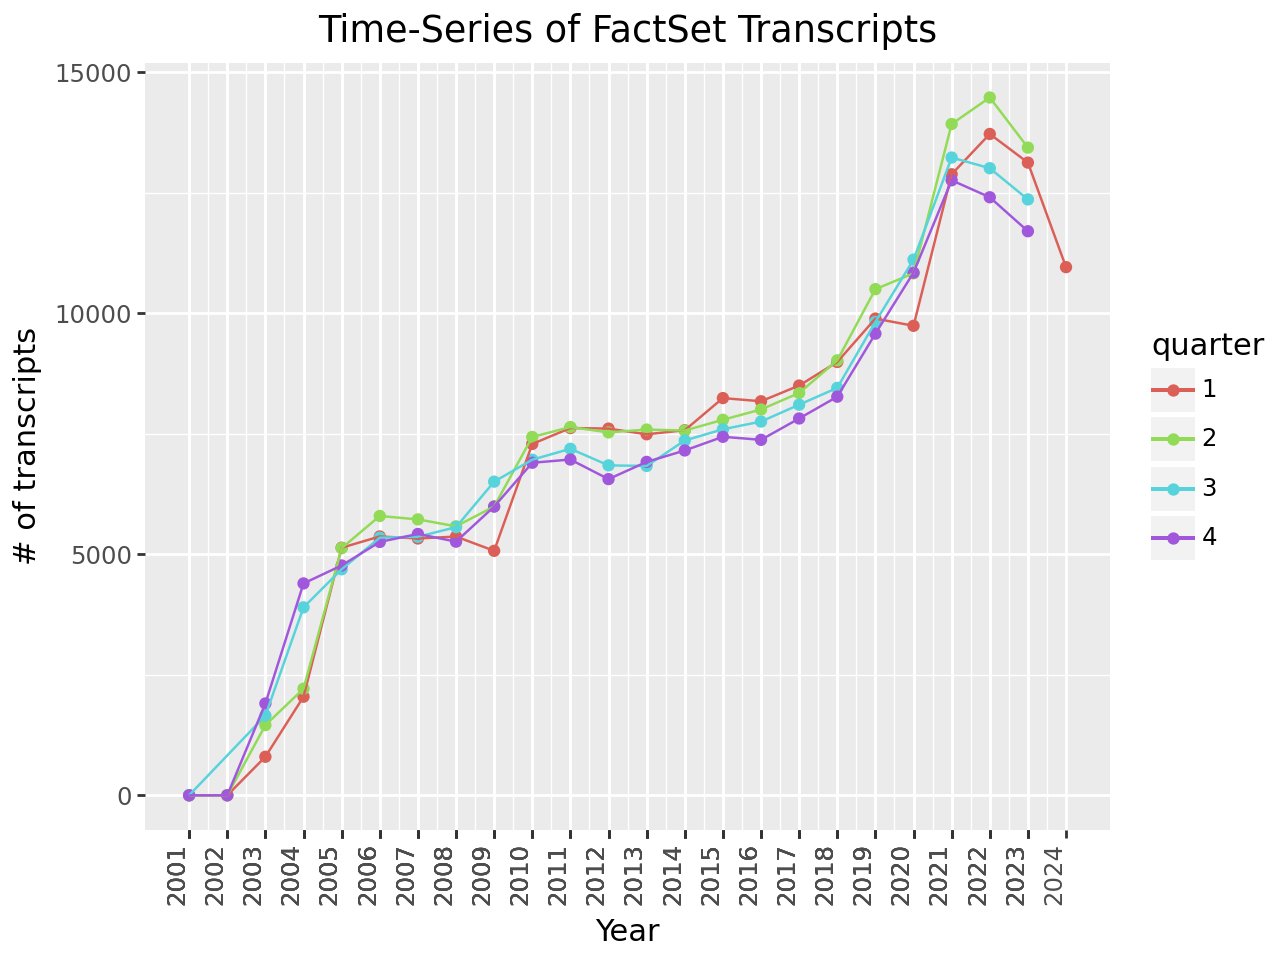

In [16]:
# create copy for plotting purposes
fs_master_plot = fs_master_accessible[['EVENT_DATETIME_UTC', 'Year', 'file_name']].copy()

# add quarter column
fs_master_plot['quarter'] = pd.to_datetime(fs_master_plot.EVENT_DATETIME_UTC).dt.quarter
# create long dataset for plotting
fs_long = fs_master_plot.groupby(['Year', 'quarter']).agg(transcripts = ('file_name', 'size')).reset_index()

(
    p9.ggplot(fs_long, p9.aes(x='Year', y='transcripts', color='factor(quarter)', group='quarter'))
    + p9.geom_point()
    + p9.geom_line() 
    + p9.scale_x_continuous(name='Year', breaks = fs_long.Year)
    + p9.scale_y_continuous(name='# of transcripts', limits=[fs_long.transcripts.min(), fs_long.transcripts.max()])
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle('Time-Series of FactSet Transcripts')
    + p9.labs(color='quarter')
)

# 5. (mercury script) Use fs_master_accessible on the shell script, fs_gets, to find out which calls are not in the Capital IQ counterpart

In [ ]:
# inspect to make sure it looks fine
get_file = pd.read_csv('../factset_gets_all_years_fill.csv')

get_file


# 6. Using its output, "factset_gets[...].csv" use call_getter to pull transcripts themselves


In [ ]:
# inspect result of script to make sure it looks fine
new_calls = pd.read_csv('../new_calls/FactSet/factset_transcripts_all_years_fill.csv')

new_calls